In [1]:
from datasets import load_dataset, load_metric, Dataset, DatasetDict
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments
from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import AutoModelWithLMHead
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
from sklearn import metrics
from scipy.special import softmax
import torch
from torch.utils.data import DataLoader
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

C:\Users\Mohsen\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


device(type='cuda')

In [2]:
df = pd.read_csv("Q3/pre_main_data.csv")
df

,id,label,tweet
0,0,2,! <user> as a woman you should not complain ab...
1,1,1,! <user> boy dats cold tyga dwn bad for cuffin...
2,2,1,! <user> dawg ! <user> you ever fuck a bitch a...
3,3,1,! <user> <user> she look like a tranny
4,4,1,! <user> the shit you hear about me might be t...
...,...,...,...
24428,25291,1,you a muthaf***in <censored> lie “ <user> <use...
24429,25292,2,you have gone and broke the wrong heart baby a...
24430,25294,1,young buck wanna eat ! dat nigguh like i aint ...
24431,25295,1,youu got wild bitches tellin you lies


In [3]:
dataset = Dataset.from_pandas(df)
trainvalid_test = dataset.train_test_split(test_size=0.3)
train_valid = trainvalid_test['train'].train_test_split(test_size=0.1)
dataset = DatasetDict({
    'train': train_valid['train'],
    'validation': train_valid['test'],
    'test': trainvalid_test['test'],
})
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'label', 'tweet'],
        num_rows: 15392
    })
    validation: Dataset({
        features: ['id', 'label', 'tweet'],
        num_rows: 1711
    })
    test: Dataset({
        features: ['id', 'label', 'tweet'],
        num_rows: 7330
    })
})

In [4]:
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def tokenize_function(example):
    return tokenizer(example["tweet"], truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["id", "tweet"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")

plm = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)
plm.to(device)

tokenized_datasets

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 15392
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1711
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 7330
    })
})

In [14]:
class Head(torch.nn.Module):
    def __init__(self, input_size=768, num_classes=3):
        super().__init__()
        self.lstm = torch.nn.LSTM(input_size=input_size, 
                                  hidden_size=384, num_layers=2, 
                                  bidirectional=True, batch_first=True).to(device)
        net_list = [
            torch.nn.Linear(768, 512),
            torch.nn.Tanh(),
            torch.nn.LayerNorm(512),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(512, num_classes)        
        ]
        self.label_net = torch.nn.Sequential(*net_list).to(device)
        self.training_criterion = torch.nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=5e-4, weight_decay=0)
        self.to(device)
        
    def forward(self, plm_last_hidden_states):  # ~[8, 34, 768]
        x, (hn, cn) = self.lstm(plm_last_hidden_states)
        x = x[:, -1, :]  # Last LSTM
        x = self.label_net(x)
        return x

In [15]:
class Trainer:
    def __init__(self, plm, tokenized_datasets, seq_to_seq=False, input_size=768):
        self.plm = plm.to(device)
        self.tokenized_datasets = tokenized_datasets
        self.head = Head(input_size=input_size).to(device)
        self.seq_to_seq = seq_to_seq
        self.dataloaders = {}
        self.dataloaders["train"] = DataLoader(
            tokenized_datasets["train"], shuffle=True, batch_size=8, collate_fn=data_collator
        )
        self.history = {"loss": {"train": [], "validation": [], "test": []},
                        "accuracy": {"train": [], "validation": [], "test": []}}
        print(self.head)
        
    
    def train(self, epochs=5):
        for epoch in tqdm(range(epochs)):
            plm.eval()
            self.head.train()
            running_loss = 0.0
            steps = 0
            for batch in tqdm(self.dataloaders["train"]):
                batch = {k: v.to(device) for k, v in batch.items()}
                if self.seq_to_seq:
                    outputs = self.plm(input_ids=batch["input_ids"], decoder_input_ids=batch["input_ids"], output_hidden_states=True)
                    encoder_hidden_states = torch.stack([val.detach() for val in outputs.encoder_hidden_states])
                    decoder_hidden_states = torch.stack([val.detach() for val in outputs.decoder_hidden_states])
                    last_hidden_states = decoder_hidden_states[-1].to(device)
                else:
                    outputs = self.plm(**batch, output_hidden_states=True, return_dict=True)
                    hidden_states = torch.stack([val.detach() for val in outputs.hidden_states])  # ~[13, 8, 34, 768]
                    last_hidden_states = hidden_states[-1].to(device)
                output = self.head(last_hidden_states)
                loss = self.head.training_criterion(output.to(device), torch.tensor(batch["labels"], dtype=torch.long))
                loss.backward()
                self.head.optimizer.step()
                self.head.optimizer.zero_grad()
                
                running_loss += loss.item()
                steps += 1
            self.update_history(epoch)
            self.plot_history()
                
    def calc_loss(self, tokenized_dataset, print_metrics=False, desc=""):
        dataloader = DataLoader(
            tokenized_dataset, batch_size=8, collate_fn=data_collator
        )
        self.head.eval()
        with torch.no_grad():
            running_loss = 0
            steps = 0
            preds = None
            for batch in tqdm(dataloader, desc=desc):
                batch = {k: v.to(device) for k, v in batch.items()}
                # forward
                if self.seq_to_seq:
                    outputs = self.plm(input_ids=batch["input_ids"], decoder_input_ids=batch["input_ids"], output_hidden_states=True)
                    encoder_hidden_states = torch.stack([val.detach() for val in outputs.encoder_hidden_states])
                    decoder_hidden_states = torch.stack([val.detach() for val in outputs.decoder_hidden_states])
                    last_hidden_states = decoder_hidden_states[-1].to(device)
                else:
                    outputs = self.plm(**batch, output_hidden_states=True, return_dict=True)
                    hidden_states = torch.stack([val.detach() for val in outputs.hidden_states])  # ~[13, 8, 34, 768]
                    last_hidden_states = hidden_states[-1].to(device)
                output = self.head(last_hidden_states)
                preds = output if preds == None else torch.cat((preds, output), 0)
                loss = self.head.training_criterion(output.to(device), 
                                                    torch.tensor(batch["labels"].clone().detach(), dtype=torch.long))
                running_loss += loss.item()
                steps += 1
            preds = preds.cpu().argmax(-1)
        y_true = np.array(tokenized_dataset["labels"])
        accuracy = sklearn.metrics.accuracy_score(y_true, preds)
        report = classification_report(y_true, preds)
        if print_metrics:
            print(report)
            self.plot_cm(y_true, preds)
        return running_loss / steps, accuracy
    
    def update_history(self, epoch, train_loss = None):
        for part in ["train", "validation", "test"]:
            loss, accuracy = self.calc_loss(self.tokenized_datasets[part], desc=f"{part} loss", print_metrics=part=="test")
            self.history["loss"][part].append(loss)
            self.history["accuracy"][part].append(accuracy)
        print(f"[Epoch {epoch + 1}] loss: {self.history['loss']['train'][-1]}, val_loss: {self.history['loss']['validation'][-1]}")
        
              
    def plot_history(self):
        for metric in ["loss", "accuracy"]:
            loss_history = self.history[metric]
            plt.plot(loss_history["train"])
            plt.plot(loss_history["validation"])
            plt.title(f"{metric} history")
            plt.legend(['Train', 'Validation'])
            plt.show()
        print("TEST RESULTS:")
        print("Test Loss:    ", self.history["loss"]["test"][-1])
        print("Test Accuracy:", self.history["accuracy"]["test"][-1])
              
    def plot_cm(self, y_true, preds):
        cm = confusion_matrix(y_true, preds)
        plt.figure(figsize=(7, 5))
        ax = sns.heatmap(cm, annot=True, fmt="d")
        bottom, top = ax.get_ylim()
        ax.set_ylim(bottom + 0.5, top - 0.5)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

In [ ]:
trainer = Trainer(plm, tokenized_datasets)
trainer.train(epochs=3)

# 3)

In [13]:
checkpoint = "GroNLP/hateBERT"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def tokenize_function(example):
    return tokenizer(example["tweet"], truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["id", "tweet"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")

plm = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)
plm.to(device)

tokenized_datasets

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

Some weights of the model checkpoint at GroNLP/hateBERT were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 15392
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1711
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 7330
    })
})

Head(
  (lstm): LSTM(768, 384, batch_first=True, bidirectional=True)
  (label_net): Sequential(
    (0): Linear(in_features=768, out_features=512, bias=True)
    (1): Tanh()
    (2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=512, out_features=3, bias=True)
  )
  (training_criterion): CrossEntropyLoss()
)


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1924 [00:00<?, ?it/s]

C:\Users\Mohsen\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss:   0%|          | 0/1924 [00:00<?, ?it/s]

C:\Users\Mohsen\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\Mohsen\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mohsen\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mohsen\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWa

validation loss:   0%|          | 0/214 [00:00<?, ?it/s]

C:\Users\Mohsen\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\Mohsen\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mohsen\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mohsen\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWa

test loss:   0%|          | 0/917 [00:00<?, ?it/s]

C:\Users\Mohsen\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       396
           1       0.90      0.97      0.93      5722
           2       0.83      0.79      0.81      1212

    accuracy                           0.89      7330
   macro avg       0.58      0.59      0.58      7330
weighted avg       0.84      0.89      0.86      7330



C:\Users\Mohsen\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mohsen\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mohsen\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


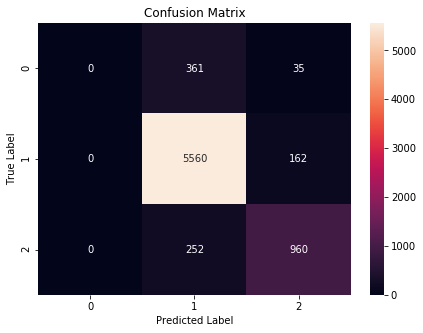

[Epoch 1] loss: 0.30202788754468957, val_loss: 0.2908504176971929


  0%|          | 0/1924 [00:00<?, ?it/s]

C:\Users\Mohsen\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss:   0%|          | 0/1924 [00:00<?, ?it/s]

C:\Users\Mohsen\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


validation loss:   0%|          | 0/214 [00:00<?, ?it/s]

C:\Users\Mohsen\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


test loss:   0%|          | 0/917 [00:00<?, ?it/s]

C:\Users\Mohsen\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


              precision    recall  f1-score   support

           0       0.44      0.10      0.16       396
           1       0.90      0.98      0.94      5722
           2       0.87      0.75      0.80      1212

    accuracy                           0.89      7330
   macro avg       0.74      0.61      0.64      7330
weighted avg       0.87      0.89      0.87      7330



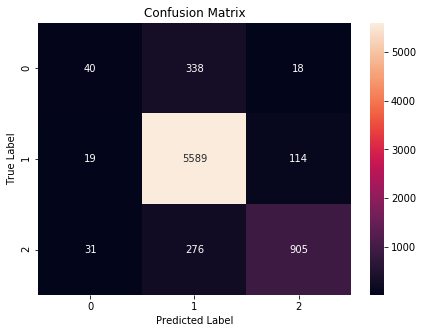

[Epoch 2] loss: 0.2585049317021837, val_loss: 0.27149651097307836


  0%|          | 0/1924 [00:00<?, ?it/s]

C:\Users\Mohsen\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss:   0%|          | 0/1924 [00:00<?, ?it/s]

C:\Users\Mohsen\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


validation loss:   0%|          | 0/214 [00:00<?, ?it/s]

C:\Users\Mohsen\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


test loss:   0%|          | 0/917 [00:00<?, ?it/s]

C:\Users\Mohsen\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


              precision    recall  f1-score   support

           0       0.52      0.33      0.41       396
           1       0.94      0.95      0.95      5722
           2       0.82      0.90      0.86      1212

    accuracy                           0.91      7330
   macro avg       0.76      0.73      0.74      7330
weighted avg       0.90      0.91      0.90      7330



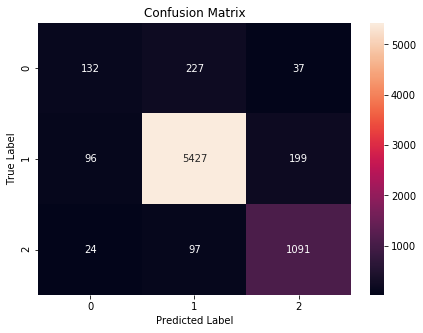

[Epoch 3] loss: 0.21240579836378395, val_loss: 0.2520149628170461


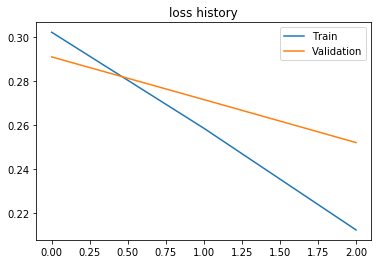

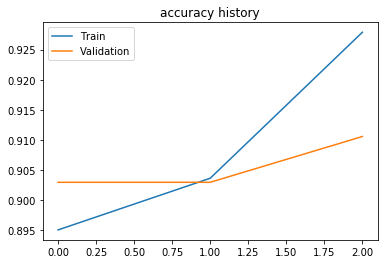

TEST RESULTS:
Test Loss:     0.2576577066603313
Test Accuracy: 0.9072305593451568


In [11]:
trainer = Trainer(plm, tokenized_datasets)
trainer.train(epochs=3)

# 5)

In [7]:
checkpoint = "t5-small"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def tokenize_function(example):
    return tokenizer(example["tweet"], truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["id", "tweet"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")

plm = AutoModelWithLMHead.from_pretrained(checkpoint, num_labels=3)
plm.to(device)

tokenized_datasets

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

C:\Users\Mohsen\Anaconda3\lib\site-packages\transformers\models\auto\modeling_auto.py:911: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,


DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 15392
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 1711
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 7330
    })
})

Head(
  (lstm): LSTM(512, 384, batch_first=True, bidirectional=True)
  (label_net): Sequential(
    (0): Linear(in_features=768, out_features=512, bias=True)
    (1): Tanh()
    (2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=512, out_features=3, bias=True)
  )
  (training_criterion): CrossEntropyLoss()
)


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1924 [00:00<?, ?it/s]

C:\Users\Mohsen\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss:   0%|          | 0/1924 [00:00<?, ?it/s]

C:\Users\Mohsen\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\Mohsen\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mohsen\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mohsen\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWa

validation loss:   0%|          | 0/214 [00:00<?, ?it/s]

C:\Users\Mohsen\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\Mohsen\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mohsen\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mohsen\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWa

test loss:   0%|          | 0/917 [00:00<?, ?it/s]

C:\Users\Mohsen\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       439
           1       0.78      1.00      0.87      5674
           2       0.69      0.01      0.02      1217

    accuracy                           0.78      7330
   macro avg       0.49      0.34      0.30      7330
weighted avg       0.71      0.78      0.68      7330



C:\Users\Mohsen\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mohsen\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mohsen\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


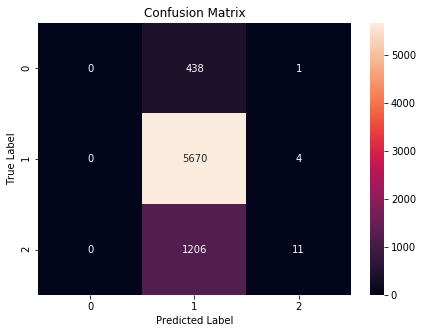

[Epoch 1] loss: 0.6287467031973935, val_loss: 0.6352727697970711


  0%|          | 0/1924 [00:00<?, ?it/s]

C:\Users\Mohsen\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss:   0%|          | 0/1924 [00:00<?, ?it/s]

C:\Users\Mohsen\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\Mohsen\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mohsen\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mohsen\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWa

validation loss:   0%|          | 0/214 [00:00<?, ?it/s]

C:\Users\Mohsen\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\Mohsen\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mohsen\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mohsen\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWa

test loss:   0%|          | 0/917 [00:00<?, ?it/s]

C:\Users\Mohsen\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       439
           1       0.82      0.99      0.89      5674
           2       0.72      0.28      0.40      1217

    accuracy                           0.81      7330
   macro avg       0.51      0.42      0.43      7330
weighted avg       0.75      0.81      0.76      7330



C:\Users\Mohsen\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mohsen\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mohsen\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


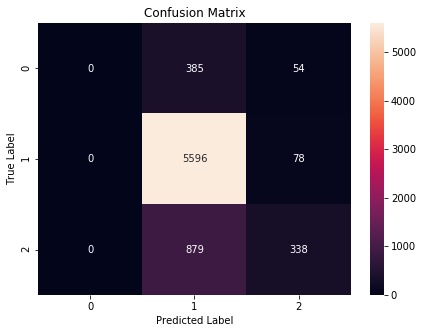

[Epoch 2] loss: 0.5394897651539151, val_loss: 0.5539778702169935


  0%|          | 0/1924 [00:00<?, ?it/s]

C:\Users\Mohsen\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss:   0%|          | 0/1924 [00:00<?, ?it/s]

C:\Users\Mohsen\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\Mohsen\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mohsen\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mohsen\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWa

validation loss:   0%|          | 0/214 [00:00<?, ?it/s]

C:\Users\Mohsen\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\Mohsen\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mohsen\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mohsen\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWa

test loss:   0%|          | 0/917 [00:00<?, ?it/s]

C:\Users\Mohsen\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       439
           1       0.94      0.90      0.92      5674
           2       0.60      0.96      0.74      1217

    accuracy                           0.85      7330
   macro avg       0.52      0.62      0.55      7330
weighted avg       0.83      0.85      0.83      7330



C:\Users\Mohsen\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mohsen\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mohsen\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


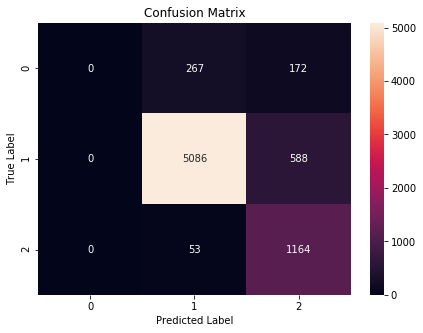

[Epoch 3] loss: 0.3970636044805114, val_loss: 0.4006013709738433


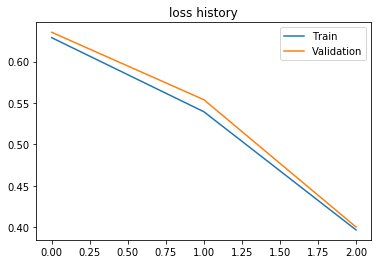

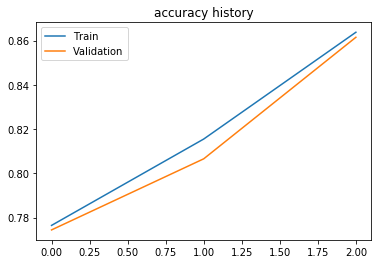

TEST RESULTS:
Test Loss:     0.4215807894909005
Test Accuracy: 0.8526603001364257


In [10]:
trainer = Trainer(plm, tokenized_datasets, seq_to_seq=True, input_size=512)
trainer.train(epochs=3)

# 91%)

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

Some weights of the model checkpoint at GroNLP/hateBERT were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly

Head(
  (lstm): LSTM(768, 384, num_layers=2, batch_first=True, bidirectional=True)
  (label_net): Sequential(
    (0): Linear(in_features=768, out_features=512, bias=True)
    (1): Tanh()
    (2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=512, out_features=3, bias=True)
  )
  (training_criterion): CrossEntropyLoss()
)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1924 [00:00<?, ?it/s]

C:\Users\Mohsen\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss:   0%|          | 0/1924 [00:00<?, ?it/s]

C:\Users\Mohsen\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


validation loss:   0%|          | 0/214 [00:00<?, ?it/s]

C:\Users\Mohsen\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


test loss:   0%|          | 0/917 [00:00<?, ?it/s]

C:\Users\Mohsen\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


              precision    recall  f1-score   support

           0       0.39      0.41      0.40       439
           1       0.95      0.91      0.93      5674
           2       0.78      0.90      0.84      1217

    accuracy                           0.88      7330
   macro avg       0.71      0.74      0.72      7330
weighted avg       0.89      0.88      0.88      7330



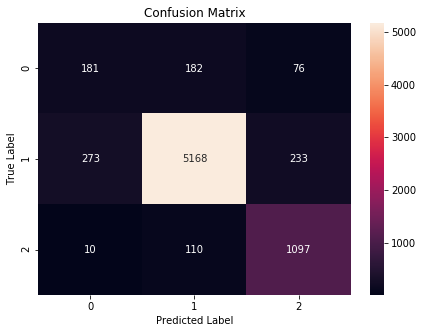

[Epoch 1] loss: 0.2973779190773156, val_loss: 0.3215375233650486


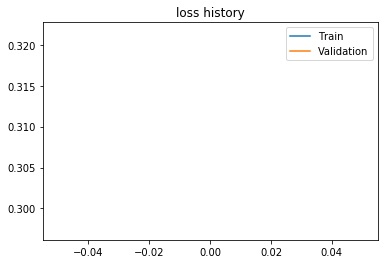

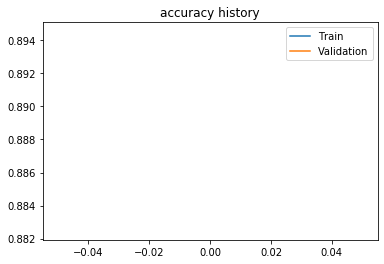

TEST RESULTS:
Test Loss:     0.3345792978685126
Test Accuracy: 0.879399727148704


  0%|          | 0/1924 [00:00<?, ?it/s]

C:\Users\Mohsen\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [ ]:
checkpoint = "GroNLP/hateBERT"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def tokenize_function(example):
    return tokenizer(example["tweet"], truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["id", "tweet"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")

plm = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)
plm.to(device)

tokenized_datasets

trainer = Trainer(plm, tokenized_datasets)
trainer.train(epochs=10)